# AirPump failures

A customer is manufacturing devices containing air pumps that provide pressure for a machine cycle. Ideally, the air pressure rises sharply and remains stable throughout the machine's cycle, where it drops sharply. However, it can happen that the air pressure drops due to pump failure, or the air pressure rises or drops slowly.

The goal of the project is to detect a pump failure.
The typical air pump failure is a temporary pressure decrease in the first half of the cycle.


## Data structure


### Data

The data consists of the following columns (in this particular order):

- MachineId - Id of the machine
- MeasurementId - Id of the measured cycle
- Pressure - Air pressure (kPa)

The data does not contain timestamps, but for each machine and measured cycle combination, observations (i.e. rows) of the pressure values are ordered by time, and the time intervals between individual observations are always the same.

### Labels

The labels consists of the following columns (in this particular order):

- MachineId - Id of the machine
- MeasurementId - Id of the measured cycle
- PumpFailed - True if pump failed
- SlowStart - True if the pressure rised slowly
- SlowEnd - True if the pressure dropped slowly

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
#data loading
data = pd.read_parquet("data/data.parquet")
labels = pd.read_csv("data/labels.csv")

### Data Exploration

In [3]:
data

,MachineId,MeasurementId,Pressure
0,0_0_0,0,0.0
1,0_0_0,0,0.0
2,0_0_0,0,0.0
3,0_0_0,0,0.0
4,0_0_0,0,0.0
...,...,...,...
18466359,10_0_3,8834,0.0
18466360,10_0_3,8834,0.0
18466361,10_0_3,8834,0.0
18466362,10_0_3,8834,0.0


In [4]:
labels

,MachineId,MeasurementId,PumpFailed,SlowStart,SlowEnd
0,0_0_0,0,False,False,False
1,0_0_1,-1,NaN,NaN,NaN
2,0_0_2,0,False,False,False
3,0_0_3,0,True,False,False
4,0_1_0,-1,NaN,NaN,NaN
...,...,...,...,...,...
27380,10_0_2,8833,False,False,False
27381,10_0_3,8833,False,False,False
27382,10_0_0,8834,False,False,False
27383,10_0_1,8834,False,False,True


In [5]:
labels.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27385 entries, 0 to 27384
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   MachineId      27385 non-null  object
 1   MeasurementId  27385 non-null  int64 
 2   PumpFailed     26900 non-null  object
 3   SlowStart      19300 non-null  object
 4   SlowEnd        19300 non-null  object
dtypes: int64(1), object(4)
memory usage: 1.0+ MB


In [7]:
#searching for duplicit values in "labels" 
labels[labels.duplicated()]

,MachineId,MeasurementId,PumpFailed,SlowStart,SlowEnd


In [8]:
#searching if numbers of measurement  which were done during each cycle are the same
data.groupby(["MachineId","MeasurementId"]).count()

Pressure
MachineId MeasurementId          
0_0_0     -1               101711
           0                  368
           215                732
           237                589
           353                349
...                           ...
9_5_3      4253               337
           4254               478
           4255               436
           4256               549
           4257               380

[27385 rows x 1 columns]

In [9]:
# -1 measurementID cycle has much higher number of measurement either in contrast to other cycles
#checking -1 MeasurementId cycle for other machiens
data[data["MeasurementId"] == -1].groupby(["MachineId"])["Pressure"].count().sort_values(ascending=False)

MachineId
0_2_0     185476
0_2_3     149535
0_2_2     135534
0_2_1     127175
0_1_1     123663
           ...  
60_2_1       271
60_2_3       271
22_0_1       231
22_0_0       231
67_2_0       226
Name: Pressure, Length: 485, dtype: int64

In [10]:
#how it looks with -1 meaID cycles in labels dataset?
labels[labels["MeasurementId"]==-1]

,MachineId,MeasurementId,PumpFailed,SlowStart,SlowEnd
1,0_0_1,-1,NaN,NaN,NaN
4,0_1_0,-1,NaN,NaN,NaN
6,0_1_2,-1,NaN,NaN,NaN
7,0_1_3,-1,NaN,NaN,NaN
9,1_0_1,-1,NaN,NaN,NaN
...,...,...,...,...,...
25788,15_0_2,-1,NaN,NaN,NaN
25789,15_0_3,-1,NaN,NaN,NaN
25792,15_0_1,-1,NaN,NaN,NaN
27018,11_2_2,-1,NaN,NaN,NaN


In [11]:
#checking how many rows with meaId -1 has null value in PumpFailed,SlowStart,SlowEnd columns
labels[labels["MeasurementId"]==-1].isna().sum()

MachineId          0
MeasurementId      0
PumpFailed       485
SlowStart        485
SlowEnd          485
dtype: int64

In [12]:
data.isna().sum()

MachineId        0
MeasurementId    0
Pressure         0
dtype: int64

In [13]:
# finding out if each machine from "data" has pair in "labels" and vice versa
all(labels["MachineId"].unique() == data["MachineId"].unique())

True

<AxesSubplot:>

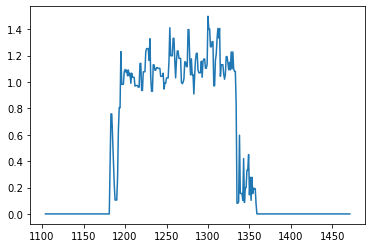

In [14]:
#checking pressure durring cycle, when pump failed/notfailed ( Ids number got from labels[labels["PumpFailed"] == True])
#Failed
data[(data["MachineId"] == "0_0_3") & (data["MeasurementId"]==0)]["Pressure"].plot()

Text(0.5, 1.0, 'Chart 2')

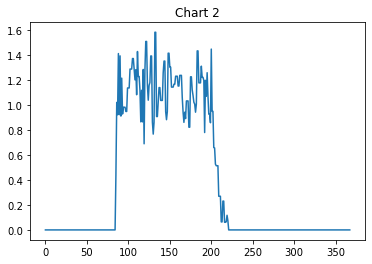

In [15]:
#not failed
data[(data["MachineId"] == "0_0_0") & (data["MeasurementId"]==0)]["Pressure"].plot()
plt.title("Chart 2")

False    23958
True      2942
Name: PumpFailed, dtype: int64

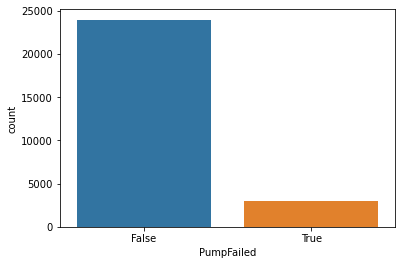

In [16]:
# checking response variable
sns.countplot(x="PumpFailed",data=labels)
labels["PumpFailed"].value_counts()
#highly unbalanced (I will pay more attention to it later)

<AxesSubplot:xlabel='PumpFailed', ylabel='Pressure_mean'>

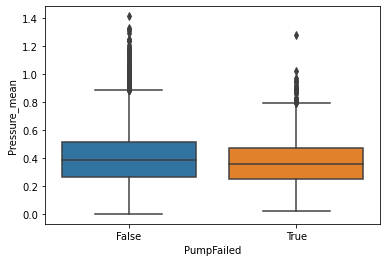

In [17]:
#joining both dataset only for some exploration purposes
temporary_dataset = pd.merge(labels,data,left_on=["MachineId","MeasurementId"],right_on=["MachineId","MeasurementId"],how="left")
temporary_dataset_grouped = temporary_dataset.groupby(["MachineId","MeasurementId","PumpFailed"]).mean().reset_index()
temporary_dataset_grouped = temporary_dataset_grouped.rename(columns={"Pressure":"Pressure_mean"})
sns.boxplot(x="PumpFailed",y="Pressure_mean",data=temporary_dataset_grouped)

<AxesSubplot:xlabel='PumpFailed', ylabel='Pressure_mean'>

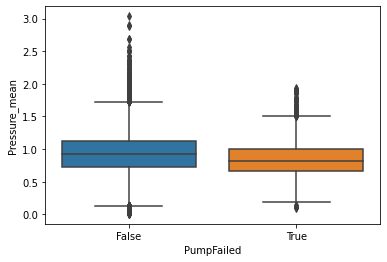

In [18]:
#filtering and plotting data where Pressure > 0
#I assume that if Pressure is zero air pump has not started working yet /or already stopped
## for example: Area between approx(0-70) & (230-350) in the "Chart 2" above 
temporary_dataset_grouped = temporary_dataset[temporary_dataset["Pressure"]>0].groupby(["MachineId","MeasurementId","PumpFailed"]).mean().reset_index()
temporary_dataset_grouped = temporary_dataset_grouped.rename(columns={"Pressure":"Pressure_mean"})
sns.boxplot(x="PumpFailed",y="Pressure_mean",data=temporary_dataset_grouped)

# ??

Some stuff found during data exploration which I don't understand and dont know how to handle. Is is anomaly and should be filtered out or not?
for example:

,MachineId,MeasurementId,PumpFailed,SlowStart,SlowEnd
26905,0_2_0,8675,False,False,False


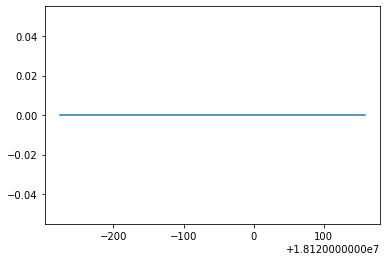

In [19]:
#Pump did not provide any air pressure but according to the data Pump did not failed and did not have Slow Start a Slow End
data[(data["MachineId"] == "0_2_0") & (data["MeasurementId"] == 8675)]["Pressure"].plot()
labels[(labels["MachineId"] == "0_2_0") & (labels["MeasurementId"] == 8675)]

,MachineId,MeasurementId,PumpFailed,SlowStart,SlowEnd
1601,0_1_2,666,False,NaN,NaN


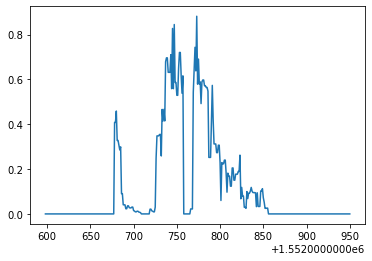

In [20]:
# Pump is referred to as not failed in this cycle even though there is temporary considerable pressure decrease in the first half of the cycle.
data[(data["MachineId"] == "0_1_2") & (data["MeasurementId"] == 666)]["Pressure"].plot()
labels[(labels["MachineId"] == "0_1_2") & (labels["MeasurementId"] == 666)]

Based on that I was wondering if there is any way to efficiently handle null values in the Pump Failed, Slow Start, Slow End columns other than dropping them out.<br>
Therefore I decided below to filter out all null values ​​even though it's not the best way.

### Data preprocessing

In [21]:
labels.isna().sum()

MachineId           0
MeasurementId       0
PumpFailed        485
SlowStart        8085
SlowEnd          8085
dtype: int64

In [22]:
labels.dropna(inplace=True)

based on information in the task ("The typical air pump failure is a temporary pressure decrease in the first half of the cycle") I decided to create another explonatory variable called "half_cycle_std". Main idea was to calculate standard deviation of non-zero values in the first half of the cycle.

In [23]:
#I defined function for doing that
def std_count(x,y):
    v_data = data[(data["MachineId"]== x) & (data["MeasurementId"]== y) & (data["Pressure"]>0)]
    v_std = v_data.head(round(len(v_data)/2))["Pressure"].std()
    return v_std

In [ ]:
#And tried to apply on on dataset
labels["half_cycle_std"] = labels.apply(lambda x: std_count(x["MachineId"],x["MeasurementId"]),axis=1)
#unfortunately without result. It would took a long time to my computer to process this command so i interrupt it.

In [24]:
#creating two more variables
#Standard deviation a mean of nonzero airpressure in each cycle
cycle_mean = data[data["Pressure"]>0].groupby(["MachineId","MeasurementId"]).mean().reset_index()

In [25]:
cycle_mean = cycle_mean.rename(columns={"Pressure":"pressure_mean"})

In [26]:
labels = pd.merge(labels,cycle_mean,how="left",left_on=["MachineId","MeasurementId"],right_on=["MachineId","MeasurementId"])

In [27]:
cycle_std = data[data["Pressure"]>0].groupby(["MachineId","MeasurementId"]).std().reset_index()

In [28]:
cycle_std = cycle_std.rename(columns={"Pressure":"std"})

In [29]:
labels = pd.merge(labels,cycle_std,how="left",left_on=["MachineId","MeasurementId"],right_on=["MachineId","MeasurementId"]).dropna()

In [30]:
labels["PumpFailed"].value_counts()

False    17077
True      2160
Name: PumpFailed, dtype: int64

In [31]:
labels

,MachineId,MeasurementId,PumpFailed,SlowStart,SlowEnd,pressure_mean,std
0,0_0_0,0,False,False,False,1.014906,0.349993
1,0_0_2,0,False,False,False,0.820910,0.188122
2,0_0_3,0,True,False,False,0.948806,0.367615
3,0_1_1,1,True,False,False,1.000889,0.272449
4,1_0_0,2,False,True,False,0.960974,0.359026
...,...,...,...,...,...,...,...
19295,10_0_2,8833,False,False,False,0.933224,0.139800
19296,10_0_3,8833,False,False,False,1.091172,0.316269
19297,10_0_0,8834,False,False,False,1.442481,0.448122
19298,10_0_1,8834,False,False,True,1.050184,0.642714


# Modeling

In [48]:
from sklearn.model_selection import train_test_split

In [49]:
#Converting True/false to 1/0
labels = labels.astype({"SlowStart":"int","SlowEnd":"int","PumpFailed":"int"})

In [50]:
#Separating data
X = labels[["SlowStart","SlowEnd","pressure_mean","std"]]
y = labels["PumpFailed"]

X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.3)

#### dealing with unbalanced dataset with SMOTE technique

In [51]:
from imblearn.over_sampling import SMOTE

In [52]:
sm = SMOTE()

In [53]:
X_train_sm,y_train_sm = sm.fit_resample(X_train, y_train)

In [54]:
print(y_train.value_counts())
print(y_train_sm.value_counts())

0    11963
1     1502
Name: PumpFailed, dtype: int64
0    11963
1    11963
Name: PumpFailed, dtype: int64


### models

In [55]:
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix

In [56]:
#Logistic Regression
lr_model = LogisticRegression()
lr_model.fit(X_train_sm,y_train_sm)
lr_pred = lr_model.predict(X_test)

In [57]:
print(confusion_matrix(y_test,lr_pred))
print(classification_report(y_test,lr_pred))

[[3703 1411]
 [ 156  502]]
              precision    recall  f1-score   support

           0       0.96      0.72      0.83      5114
           1       0.26      0.76      0.39       658

    accuracy                           0.73      5772
   macro avg       0.61      0.74      0.61      5772
weighted avg       0.88      0.73      0.78      5772



In [58]:
#KNN
knn_model = KNeighborsClassifier()
knn_model.fit(X_train_sm,y_train_sm)
knn_pred = knn_model.predict(X_test)

In [59]:
print(confusion_matrix(y_test,knn_pred))
print(classification_report(y_test,knn_pred))

[[3970 1144]
 [ 275  383]]
              precision    recall  f1-score   support

           0       0.94      0.78      0.85      5114
           1       0.25      0.58      0.35       658

    accuracy                           0.75      5772
   macro avg       0.59      0.68      0.60      5772
weighted avg       0.86      0.75      0.79      5772



In [60]:
#SVM
sv_model = SVC()
sv_model.fit(X_train_sm,y_train_sm)
sv_pred = sv_model.predict(X_test)

In [61]:
print(confusion_matrix(y_test,sv_pred))
print(classification_report(y_test,sv_pred))

[[3633 1481]
 [ 140  518]]
              precision    recall  f1-score   support

           0       0.96      0.71      0.82      5114
           1       0.26      0.79      0.39       658

    accuracy                           0.72      5772
   macro avg       0.61      0.75      0.60      5772
weighted avg       0.88      0.72      0.77      5772



In [62]:
#RandomForest
rf_model = RandomForestClassifier()
rf_model.fit(X_train_sm,y_train_sm)
rf_pred = rf_model.predict(X_test)

In [63]:
print(confusion_matrix(y_test,rf_pred))
print(classification_report(y_test,rf_pred))

[[4172  942]
 [ 306  352]]
              precision    recall  f1-score   support

           0       0.93      0.82      0.87      5114
           1       0.27      0.53      0.36       658

    accuracy                           0.78      5772
   macro avg       0.60      0.68      0.62      5772
weighted avg       0.86      0.78      0.81      5772



The best accuracy had RandomForrest, but I would say that for business is more important to detect if pump really fails so I searched for model with the best sensitivity.

In [64]:
#parameter tuning for model with best sensitivity
from sklearn.model_selection import GridSearchCV

In [66]:
parameters = {'C': [0.1, 1, 10, 100],'gamma': [1, 0.1, 0.01, 0.001]}

In [67]:
grd_svm = GridSearchCV(SVC(),parameters,refit=True,verbose=2)

In [68]:
grd_svm.fit(X_train_sm,y_train_sm)

Fitting 5 folds for each of 16 candidates, totalling 80 fits
[CV] END .....................................C=0.1, gamma=1; total time=  23.5s
[CV] END .....................................C=0.1, gamma=1; total time=  28.6s
[CV] END .....................................C=0.1, gamma=1; total time=  25.1s
[CV] END .....................................C=0.1, gamma=1; total time=  23.2s
[CV] END .....................................C=0.1, gamma=1; total time=  24.7s
[CV] END ...................................C=0.1, gamma=0.1; total time=  26.5s
[CV] END ...................................C=0.1, gamma=0.1; total time=  27.0s
[CV] END ...................................C=0.1, gamma=0.1; total time=  33.1s
[CV] END ...................................C=0.1, gamma=0.1; total time=  34.2s
[CV] END ...................................C=0.1, gamma=0.1; total time=  38.7s
[CV] END ..................................C=0.1, gamma=0.01; total time=  30.2s
[CV] END ..................................C=0.1

GridSearchCV(estimator=SVC(),
             param_grid={'C': [0.1, 1, 10, 100],
                         'gamma': [1, 0.1, 0.01, 0.001]},
             verbose=2)

In [69]:
grd_svm.best_params_

{'C': 10, 'gamma': 1}

In [70]:
prediction = grd_svm.predict(X_test)

In [74]:
print(confusion_matrix(y_test,prediction))
print(classification_report(y_test,prediction))


[[3640 1474]
 [ 140  518]]
              precision    recall  f1-score   support

           0       0.96      0.71      0.82      5114
           1       0.26      0.79      0.39       658

    accuracy                           0.72      5772
   macro avg       0.61      0.75      0.60      5772
weighted avg       0.88      0.72      0.77      5772



Text(0.5, 1.0, 'CM of SVM with default parameters')

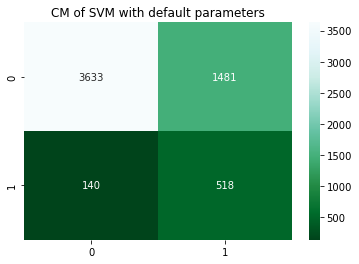

In [71]:
sns.heatmap([[3633,1481],[140,518]],annot=True,fmt='.5g',cmap="BuGn_r")
plt.title("CM of SVM with default parameters")

Text(0.5, 1.0, 'CM of SVM with tunned parameters')

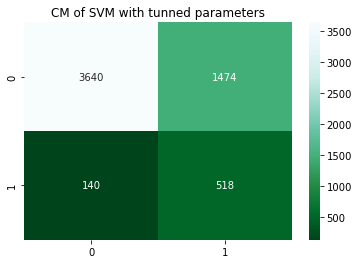

In [73]:
cm = confusion_matrix(y_test,prediction)
sns.heatmap(cm,annot=True,fmt='.5g',cmap="BuGn_r")
plt.title("CM of SVM with tunned parameters")

In [75]:
#only a small improvement TP,FN rates remained the same, TN rised and FP decreased a little bit